# This code uses periodicity from a recording as a song detector.

## It saves a .json file with all of the file names, file paths, and the time segments of detected songs. Next, it saves .npz files for each .wav file containing its hyperparameters, log amplitude traces, amplitude trace of oscillations, the power of the filtered spectrogram, and the smoothed power.

### This is the full periodicity song detector for ONE .wav file (adjust file_path in line 192 to visualize a different .wav file's calculations):

In [ ]:
# import numpy as np
# from scipy.io import wavfile
# from scipy.signal import spectrogram, windows, ellip, filtfilt
# from scipy.ndimage import gaussian_filter1d
# import matplotlib.pyplot as plt
# import tkinter as tk


# # ── Helper: approximate screen size in inches ────────────────────────────────
# def get_screen_resolution():
#     root = tk.Tk()
#     root.withdraw()
#     w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
#     root.destroy()
#     return w_px / 100, h_px / 100


# SCREEN_W, SCREEN_H = get_screen_resolution()


# # ── Core routine ──────────────────────────────────────────────────────────────
# def plot_spectrograms_by_segment(
#     file_path: str,
#     segment_duration: int = 10,
#     low_cut: int = 500,
#     high_cut: int = 8000,
#     smoothing_sigma: float = 3,
#     power_threshold: float = 0.5,
# ):
#     """
#     Visualise an audio file in multiple synced panels and highlight sections
#     whose smoothed 10–40 Hz modulation power exceeds `power_threshold`.
#     """

#     try:
#         # 1. ── load & band‑pass filter ──────────────────────────────────────
#         sr, data = wavfile.read(file_path)
#         if data.ndim > 1:  # stereo → mono
#             data = data.mean(axis=1)

#         nyquist = sr / 2
#         b, a = ellip(5, 0.2, 40, [low_cut / nyquist, high_cut / nyquist], btype="band")
#         data = filtfilt(b, a, data)

#         # 2. ── segment bookkeeping ─────────────────────────────────────────
#         seg_len_samples = segment_duration * sr
#         n_segments = int(np.ceil(len(data) / seg_len_samples))

#         figs, axs = {}, {}
#         figs["spec"], axs["spec"] = plt.subplots(
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.7), sharex=True
#         )
#         figs["logA"], axs["logA"] = plt.subplots(
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.3), sharex=True
#         )
#         figs["amps"], axs["amps"] = plt.subplots(
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.5), sharex=True
#         )
#         figs["pow"], axs["pow"] = plt.subplots(
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.3), sharex=True
#         )
#         figs["smooth"], axs["smooth"] = plt.subplots(
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.3), sharex=True
#         )
#         plt.subplots_adjust(hspace=0.3)

#         # If only one segment, wrap axes in list for uniform handling
#         for key in axs:
#             if n_segments == 1:
#                 axs[key] = [axs[key]]

#         MOD_LOW, MOD_HIGH = 5, 50  # modulation band (Hz)

#         # 3. ── loop over each segment ──────────────────────────────────────
#         for i in range(n_segments):
#             start, end = i * seg_len_samples, (i + 1) * seg_len_samples
#             segment = np.zeros(seg_len_samples, dtype=data.dtype)
#             segment[: max(0, min(len(data) - start, seg_len_samples))] = data[start:end]

#             # 3a. Main audio spectrogram ------------------------------------
#             f, t, Sxx = spectrogram(
#                 segment,
#                 fs=sr,
#                 window=windows.gaussian(2048, std=2048 / 8),
#                 nperseg=2048,
#                 noverlap=2048 - 119,
#             )
#             Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
#             Sxx_norm = (np.clip(Sxx_log, -2, None) - Sxx_log.min()) / (
#                 Sxx_log.max() - Sxx_log.min()
#             )

#             axs["spec"][i].imshow(
#                 Sxx_norm,
#                 aspect="auto",
#                 origin="lower",
#                 extent=[0, segment_duration, f.min(), f.max()],
#                 cmap="binary",
#             )
#             axs["spec"][i].set_yticks([])
#             if i == n_segments - 1:
#                 axs["spec"][i].set_xlabel("Time [s]")

#             # 3b. Log‑amplitude trace --------------------------------------
#             mask = (f >= low_cut) & (f <= high_cut)
#             log_amp = np.log10(
#                 np.sum(Sxx[mask, :], axis=0) + np.finfo(float).eps
#             )
#             axs["logA"][i].plot(t, log_amp, color="black")
#             axs["logA"][i].set_xlim(0, segment_duration)
#             if i == n_segments - 1:
#                 axs["logA"][i].set_xlabel("Time [s]")
#                 axs["logA"][i].set_xticks(np.linspace(0, segment_duration, 5))
#             else:
#                 axs["logA"][i].set_xticks([])

#             # 3c. Spectrogram of amplitude trace (WITH extra padding) -------
#             amp_fs = len(t) / segment_duration
#             nper = 128
#             pad = nper // 2
#             padded_log_amp = np.pad(
#                 log_amp,
#                 (pad, pad + int(segment_duration * amp_fs) - len(log_amp)),
#                 mode="constant",
#             )
#             f_amp, t_amp_raw, Sxx_amp = spectrogram(
#                 padded_log_amp, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
#             )
#             t_amp = t_amp_raw - pad / amp_fs  # shift so t=0 aligns with panel start

#             # ---- NEW : make sure we reach the full segment duration -------
#             if t_amp[-1] < segment_duration:
#                 # How many additional columns do we need?
#                 extra_cols = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
#                 Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra_cols)), mode="constant")
#                 # Extend the time axis accordingly
#                 t_extra = t_amp[-1] + np.arange(1, extra_cols + 1) / amp_fs
#                 t_amp = np.concatenate((t_amp, t_extra))

#             axs["amps"][i].imshow(
#                 Sxx_amp,
#                 aspect="auto",
#                 origin="lower",
#                 extent=[0, segment_duration, f_amp.min(), f_amp.max()],
#                 cmap="binary",
#             )
#             axs["amps"][i].set_ylim(0, 50)
#             axs["amps"][i].set_xlim(0, segment_duration)
#             if i == n_segments - 1:
#                 axs["amps"][i].set_xlabel("Time [s]")
#                 axs["amps"][i].set_xticks(np.linspace(0, segment_duration, 5))
#             else:
#                 axs["amps"][i].set_xticks([])

#             # 3d. Modulation‑band power (pad if needed so it matches t_amp) --
#             mod_mask = (f_amp >= MOD_LOW) & (f_amp <= MOD_HIGH)
#             mod_pow = np.sum(Sxx_amp[mod_mask, :], axis=0)

#             axs["pow"][i].plot(t_amp, mod_pow, color="purple")
#             axs["pow"][i].set_xlim(0, segment_duration)
#             if i == n_segments - 1:
#                 axs["pow"][i].set_xlabel("Time [s]")
#                 axs["pow"][i].set_xticks(np.linspace(0, segment_duration, 5))
#             else:
#                 axs["pow"][i].set_xticks([])

#             # 3e. Smoothed power + threshold + detections -------------------
#             smooth_pow = gaussian_filter1d(mod_pow, sigma=smoothing_sigma)
#             ax_sp = axs["smooth"][i]
#             ax_sp.plot(t_amp, smooth_pow, color="blue", label="Smoothed power")
#             ax_sp.axhline(
#                 power_threshold,
#                 color="red",
#                 ls="--",
#                 linewidth=1.2,
#                 label=f"Threshold = {power_threshold}",
#             )
#             ax_sp.set_xlim(0, segment_duration)
#             ax_sp.legend(fontsize="x-small", loc="upper right")

#             # Highlight detections
#             above = smooth_pow > power_threshold
#             if above.any():
#                 in_span = False
#                 for j, flag in enumerate(above):
#                     if flag and not in_span:
#                         in_span = True
#                         t_start = t_amp[j]
#                     elif not flag and in_span:
#                         ax_sp.axvspan(t_start, t_amp[j], color="yellow", alpha=0.3)
#                         axs["spec"][i].axvspan(
#                             t_start, t_amp[j], color="yellow", alpha=0.2
#                         )
#                         in_span = False
#                 if in_span:  # ran off the end
#                     ax_sp.axvspan(t_start, segment_duration, color="yellow", alpha=0.3)
#                     axs["spec"][i].axvspan(
#                         t_start, segment_duration, color="yellow", alpha=0.2
#                     )

#             if i == n_segments - 1:
#                 ax_sp.set_xlabel("Time [s]")
#                 ax_sp.set_xticks(np.linspace(0, segment_duration, 5))
#             else:
#                 ax_sp.set_xticks([])

#         # 4. ── figure titles ───────────────────────────────────────────────
#         figs["spec"].suptitle("Spectrograms (Detected Song Highlighted)", fontsize=14)
#         figs["logA"].suptitle("Log‑Amplitude Traces", fontsize=14)
#         figs["amps"].suptitle("Amplitude Trace Oscillations", fontsize=14)
#         figs["pow"].suptitle(
#             f"Power of Amplitude Trace (Band‑pass {low_cut}–{high_cut} Hz)", fontsize=14
#         )
#         figs["smooth"].suptitle(
#             f"Smoothed Power (Band‑pass {low_cut}–{high_cut} Hz, "
#             f"σ = {smoothing_sigma}, thr = {power_threshold})",
#             fontsize=14,
#         )

#         plt.show()

#     except (OSError, ValueError) as err:
#         print(f"Error processing {file_path}: {err}")


# # ── Example usage ─────────────────────────────────────────────────────────────
# if __name__ == "__main__":
#     FILE_PATH = (
#         "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
#         "data_inputs/USA5510_debug_segmenter/sample_wav_files/"
#         "USA5510_45755.26030477_4_8_7_13_50.wav"
#     )

#     plot_spectrograms_by_segment(
#         FILE_PATH,
#         segment_duration=10,
#         low_cut=1200,
#         high_cut=7000,
#         smoothing_sigma=2,
#         power_threshold=0.2,
#     )


In [3]:
# import numpy as np
# from scipy.io import wavfile
# from scipy.signal import spectrogram, windows, ellip, filtfilt
# from scipy.ndimage import gaussian_filter1d
# import matplotlib.pyplot as plt
# import tkinter as tk


# # ── Helper: screen size (≈100 dpi) ────────────────────────────────────────────
# def get_screen_resolution():
#     root = tk.Tk(); root.withdraw()
#     w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
#     root.destroy()
#     return w_px / 100, h_px / 100


# SCREEN_W, SCREEN_H = get_screen_resolution()


# # ── Core routine ─────────────────────────────────────────────────────────────
# def plot_spectrograms_by_segment(
#     file_path: str,
#     segment_duration: int = 10,
#     low_cut: int = 2000,
#     high_cut: int = 5000,
#     smoothing_sigma: float = 3,
#     power_threshold: float = 0.5,
# ):

#     """
#     Visualise an audio file in multiple synced panels and highlight sections
#     whose smoothed 10–40 Hz modulation power exceeds `power_threshold`.

#     Raw power  = grey;  Smoothed power = black.
#     The power figure is created before (and therefore appears before) the
#     spectrogram figure.
#     """
#     try:
#         # 1) Load & band‑pass filter ------------------------------------------------
#         sr, data = wavfile.read(file_path)
#         if data.ndim > 1:
#             data = data.mean(axis=1)

#         b, a = ellip(
#             5, 0.2, 40,
#             [low_cut / (sr / 2), high_cut / (sr / 2)],
#             btype="band"
#         )
#         data = filtfilt(b, a, data)

#         # 2) Segment bookkeeping ----------------------------------------------------
#         seg_len = segment_duration * sr
#         n_segments = int(np.ceil(len(data) / seg_len))

#         figs, axs = {}, {}

#         # ---- order of creation matters for window stacking -----------------------
#         figs["logA"],  axs["logA"]  = plt.subplots(
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.3), sharex=True
#         )
#         figs["amps"],  axs["amps"]  = plt.subplots(
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.5), sharex=True
#         )
#         figs["smooth"], axs["smooth"] = plt.subplots(          # <-- power first
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.35), sharex=True
#         )
#         figs["spec"],  axs["spec"]  = plt.subplots(            # <-- spec second
#             n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.7), sharex=True
#         )
#         plt.subplots_adjust(hspace=0.3)

#         # Ensure single‑segment cases behave the same
#         for key in axs:
#             if n_segments == 1:
#                 axs[key] = [axs[key]]

#         MOD_LOW, MOD_HIGH = 5, 50  # modulation band (Hz)

#         # 3) Per‑segment processing -----------------------------------------------
#         for i in range(n_segments):
#             # ---- slice (zero‑pad last chunk) ------------------------------------
#             start, end = i * seg_len, min((i + 1) * seg_len, len(data))
#             segment = np.zeros(seg_len, dtype=data.dtype)
#             segment[: end - start] = data[start:end]

#             # ---- audio spectrogram ---------------------------------------------
#             f, t, Sxx = spectrogram(
#                 segment, fs=sr,
#                 window=windows.gaussian(2048, std=2048 / 8),
#                 nperseg=2048, noverlap=2048 - 119
#             )
#             Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
#             Sxx_norm = (np.clip(Sxx_log, -2, None) - Sxx_log.min()) / (Sxx_log.ptp())

#             axs["spec"][i].imshow(
#                 Sxx_norm, cmap="binary", origin="lower", aspect="auto",
#                 extent=[0, segment_duration, f.min(), f.max()]
#             )
#             axs["spec"][i].set_yticks([])
#             if i == n_segments - 1:
#                 axs["spec"][i].set_xlabel("Time [s]")

#             # ---- log‑amplitude trace -------------------------------------------
#             mask_audio = (f >= low_cut) & (f <= high_cut)
#             log_amp = np.log10(np.sum(Sxx[mask_audio, :], axis=0) + np.finfo(float).eps)

#             axs["logA"][i].plot(t, log_amp, color="black")
#             axs["logA"][i].set_xlim(0, segment_duration)
#             if i == n_segments - 1:
#                 axs["logA"][i].set_xlabel("Time [s]")
#                 axs["logA"][i].set_xticks(np.linspace(0, segment_duration, 5))
#             else:
#                 axs["logA"][i].set_xticks([])

#             # ---- amplitude‑trace spectrogram (padded) ---------------------------
#             amp_fs = len(t) / segment_duration
#             nper   = 128
#             pad    = nper // 2
#             padded = np.pad(
#                 log_amp,
#                 (pad, pad + int(segment_duration * amp_fs) - len(log_amp)),
#                 mode="constant"
#             )
#             f_amp, t_amp_raw, Sxx_amp = spectrogram(
#                 padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
#             )
#             t_amp = t_amp_raw - pad / amp_fs

#             if t_amp[-1] < segment_duration:
#                 extra = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
#                 Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra)), mode="constant")
#                 t_amp = np.concatenate([t_amp, t_amp[-1] + np.arange(1, extra + 1) / amp_fs])

#             axs["amps"][i].imshow(
#                 Sxx_amp, cmap="binary", origin="lower", aspect="auto",
#                 extent=[0, segment_duration, f_amp.min(), f_amp.max()]
#             )
#             axs["amps"][i].set_ylim(0, 50)
#             axs["amps"][i].set_xlim(0, segment_duration)
#             if i == n_segments - 1:
#                 axs["amps"][i].set_xlabel("Time [s]")
#                 axs["amps"][i].set_xticks(np.linspace(0, segment_duration, 5))
#             else:
#                 axs["amps"][i].set_xticks([])

#             # ---- modulation‑band power & smoothing -----------------------------
#             mod_mask = (f_amp >= MOD_LOW) & (f_amp <= MOD_HIGH)
#             raw_pow  = np.sum(Sxx_amp[mod_mask, :], axis=0)
#             smooth   = gaussian_filter1d(raw_pow, sigma=smoothing_sigma)

#             # ---- combined power panel ------------------------------------------
#             ax_p = axs["smooth"][i]
#             ax_p.plot(t_amp, raw_pow,   color="grey",  alpha=0.7, label="Raw power")
#             ax_p.plot(t_amp, smooth,    color="black",            label="Smoothed power")
#             ax_p.axhline(power_threshold, color="red", ls="--", lw=1.2,
#                          label=f"Threshold = {power_threshold}")
#             ax_p.set_xlim(0, segment_duration)

#             # Highlight detections
#             detect = smooth > power_threshold
#             if detect.any():
#                 in_span = False
#                 for j, flag in enumerate(detect):
#                     if flag and not in_span:
#                         in_span, t_start = True, t_amp[j]
#                     elif not flag and in_span:
#                         ax_p.axvspan(t_start, t_amp[j], color="yellow", alpha=0.3)
#                         axs["spec"][i].axvspan(t_start, t_amp[j], color="yellow", alpha=0.2)
#                         in_span = False
#                 if in_span:
#                     ax_p.axvspan(t_start, segment_duration, color="yellow", alpha=0.3)
#                     axs["spec"][i].axvspan(t_start, segment_duration, color="yellow", alpha=0.2)

#             if i == n_segments - 1:
#                 ax_p.set_xlabel("Time [s]")
#                 ax_p.set_xticks(np.linspace(0, segment_duration, 5))
#             else:
#                 ax_p.set_xticks([])

#             if i == 0:
#                 ax_p.legend(fontsize="x-small", loc="upper right")

#         # 4) Figure titles --------------------------------------------------------
#         figs["logA"].suptitle("Log‑Amplitude Traces", fontsize=14)
#         figs["amps"].suptitle("Amplitude Trace Oscillations", fontsize=14)
#         figs["smooth"].suptitle(
#             f"Raw & Smoothed Power (band {low_cut}–{high_cut} Hz, σ = {smoothing_sigma}, thr = {power_threshold})",
#             fontsize=14
#         )
#         figs["spec"].suptitle("Spectrograms (Detected Song Highlighted)", fontsize=14)

#         plt.show()

#     except (OSError, ValueError) as err:
#         print(f"Error processing {file_path}: {err}")


# # ── Example usage ────────────────────────────────────────────────────────────
# if __name__ == "__main__":
#     FILE_PATH = (
#         "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
#         "data_inputs/USA5510_debug_segmenter/sample_wav_files/"
#         "USA5510_45755.26030477_4_8_7_13_50.wav"
#     )

#     plot_spectrograms_by_segment(
#         FILE_PATH,
#         segment_duration=10,
#         low_cut=300,
#         high_cut=5000,
#         smoothing_sigma=2,
#         power_threshold=0.2,
#     )


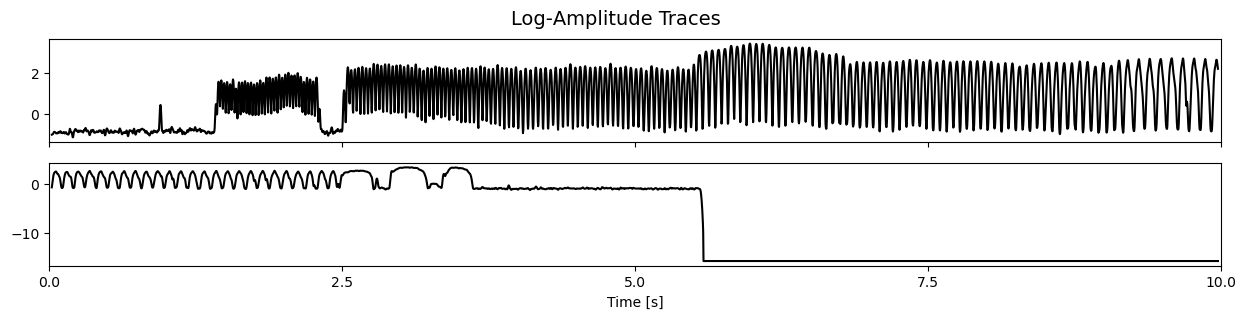

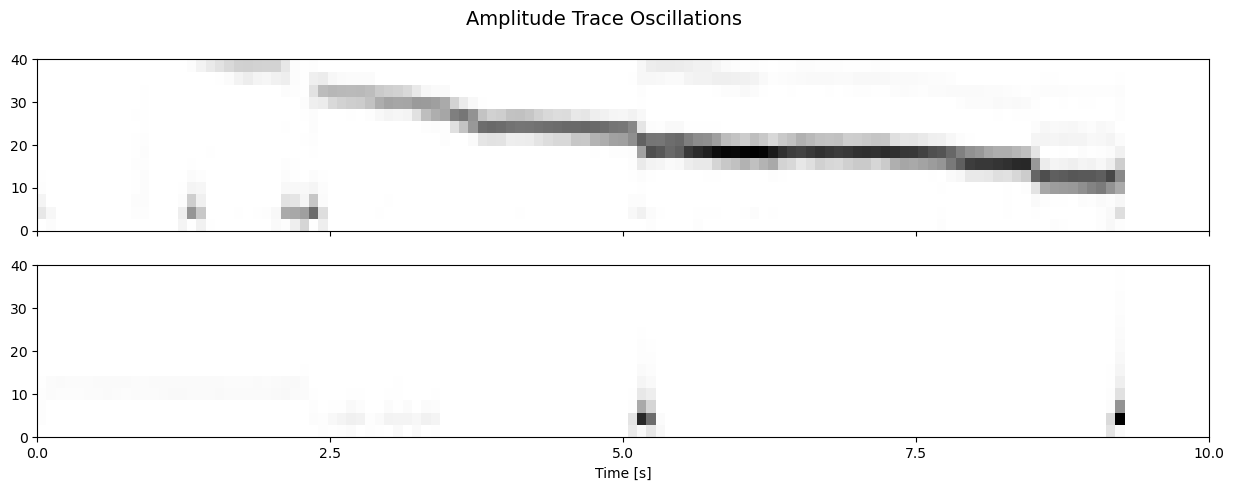

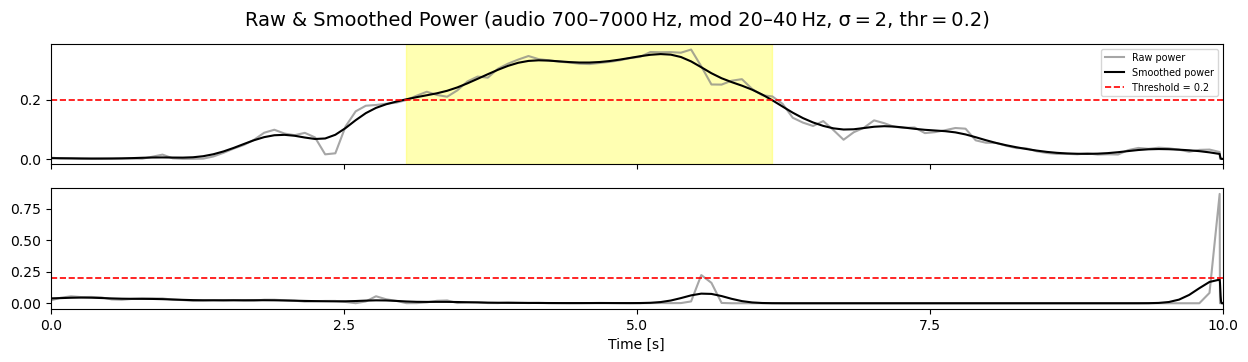

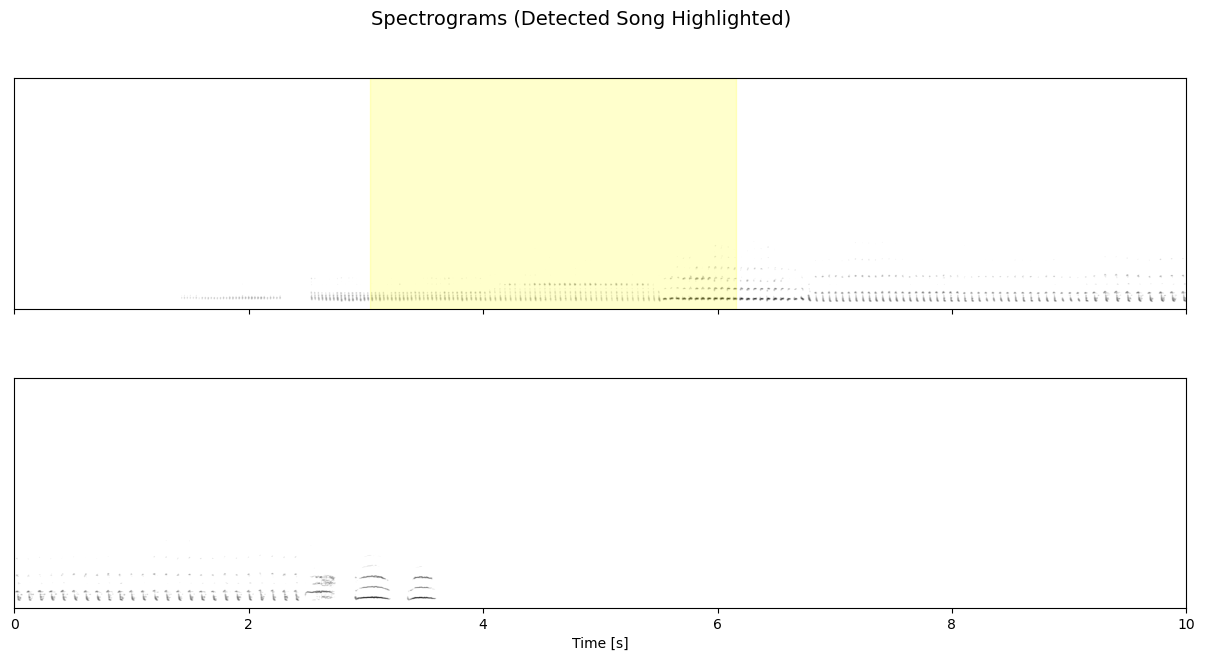

In [8]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-
"""
Visualise an audio file in stacked panels:
  • log‑amplitude trace
  • amplitude‑envelope modulation spectrogram
  • raw & smoothed modulation‑band power (with detections)
  • full audio spectrogram

User‑tunable parameters:
  ─ segment_duration     – seconds per panel
  ─ low_cut / high_cut   – audio band‑pass (Hz)
  ─ mod_low  / mod_high  – modulation‑frequency band for power (Hz)   <── NEW
  ─ smoothing_sigma      – Gaussian σ for smoothing the power trace
  ─ power_threshold      – detection threshold (same arbitrary units as power)
"""

import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk


# ── Helper: screen size (≈100 dpi) ────────────────────────────────────────────
def get_screen_resolution():
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100


SCREEN_W, SCREEN_H = get_screen_resolution()


# ── Core routine ─────────────────────────────────────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: int = 10,
    low_cut: int = 500,
    high_cut: int = 8000,
    mod_low: int = 5,               # ── NEW ──
    mod_high: int = 50,             # ── NEW ──
    smoothing_sigma: float = 3,
    power_threshold: float = 0.5,
):
    """
    Visualise an audio file in multiple synced panels and highlight sections
    whose smoothed `mod_low–mod_high` Hz modulation power exceeds
    `power_threshold`.

    Raw power  = grey;  Smoothed power = black.
    The power figure is created before (and therefore appears before) the
    spectrogram figure.
    """
    try:
        # 1) Load & band‑pass filter ------------------------------------------------
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        b, a = ellip(
            5, 0.2, 40,
            [low_cut / (sr / 2), high_cut / (sr / 2)],
            btype="band"
        )
        data = filtfilt(b, a, data)

        # 2) Segment bookkeeping ----------------------------------------------------
        seg_len = segment_duration * sr
        n_segments = int(np.ceil(len(data) / seg_len))

        figs, axs = {}, {}

        # ---- order of creation matters for window stacking -----------------------
        figs["logA"],  axs["logA"]  = plt.subplots(
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.3), sharex=True
        )
        figs["amps"],  axs["amps"]  = plt.subplots(
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.5), sharex=True
        )
        figs["smooth"], axs["smooth"] = plt.subplots(          # <-- power first
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.35), sharex=True
        )
        figs["spec"],  axs["spec"]  = plt.subplots(            # <-- spec second
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.7), sharex=True
        )
        plt.subplots_adjust(hspace=0.3)

        # Ensure single‑segment cases behave the same
        for key in axs:
            if n_segments == 1:
                axs[key] = [axs[key]]

        # 3) Per‑segment processing -----------------------------------------------
        for i in range(n_segments):
            # ---- slice (zero‑pad last chunk) ------------------------------------
            start, end = i * seg_len, min((i + 1) * seg_len, len(data))
            segment = np.zeros(seg_len, dtype=data.dtype)
            segment[: end - start] = data[start:end]

            # ---- audio spectrogram ---------------------------------------------
            f, t, Sxx = spectrogram(
                segment, fs=sr,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048, noverlap=2048 - 119
            )
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_norm = (np.clip(Sxx_log, -2, None) - Sxx_log.min()) / (Sxx_log.ptp())

            axs["spec"][i].imshow(
                Sxx_norm, cmap="binary", origin="lower", aspect="auto",
                extent=[0, segment_duration, f.min(), f.max()]
            )
            axs["spec"][i].set_yticks([])
            if i == n_segments - 1:
                axs["spec"][i].set_xlabel("Time [s]")

            # ---- log‑amplitude trace -------------------------------------------
            mask_audio = (f >= low_cut) & (f <= high_cut)
            log_amp = np.log10(np.sum(Sxx[mask_audio, :], axis=0) + np.finfo(float).eps)

            axs["logA"][i].plot(t, log_amp, color="black")
            axs["logA"][i].set_xlim(0, segment_duration)
            if i == n_segments - 1:
                axs["logA"][i].set_xlabel("Time [s]")
                axs["logA"][i].set_xticks(np.linspace(0, segment_duration, 5))
            else:
                axs["logA"][i].set_xticks([])

            # ---- amplitude‑trace spectrogram (padded) ---------------------------
            amp_fs = len(t) / segment_duration
            nper   = 128
            pad    = nper // 2
            padded = np.pad(
                log_amp,
                (pad, pad + int(segment_duration * amp_fs) - len(log_amp)),
                mode="constant"
            )
            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            if t_amp[-1] < segment_duration:
                extra = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
                Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra)), mode="constant")
                t_amp = np.concatenate([t_amp, t_amp[-1] + np.arange(1, extra + 1) / amp_fs])

            axs["amps"][i].imshow(
                Sxx_amp, cmap="binary", origin="lower", aspect="auto",
                extent=[0, segment_duration, f_amp.min(), f_amp.max()]
            )
            axs["amps"][i].set_ylim(0, mod_high)                  # updated
            axs["amps"][i].set_xlim(0, segment_duration)
            if i == n_segments - 1:
                axs["amps"][i].set_xlabel("Time [s]")
                axs["amps"][i].set_xticks(np.linspace(0, segment_duration, 5))
            else:
                axs["amps"][i].set_xticks([])

            # ---- modulation‑band power & smoothing -----------------------------
            mod_mask = (f_amp >= mod_low) & (f_amp <= mod_high)   # updated
            raw_pow  = np.sum(Sxx_amp[mod_mask, :], axis=0)
            smooth   = gaussian_filter1d(raw_pow, sigma=smoothing_sigma)

            # ---- combined power panel ------------------------------------------
            ax_p = axs["smooth"][i]
            ax_p.plot(t_amp, raw_pow,   color="grey",  alpha=0.7, label="Raw power")
            ax_p.plot(t_amp, smooth,    color="black",            label="Smoothed power")
            ax_p.axhline(power_threshold, color="red", ls="--", lw=1.2,
                         label=f"Threshold = {power_threshold}")
            ax_p.set_xlim(0, segment_duration)

            # Highlight detections
            detect = smooth > power_threshold
            if detect.any():
                in_span = False
                for j, flag in enumerate(detect):
                    if flag and not in_span:
                        in_span, t_start = True, t_amp[j]
                    elif not flag and in_span:
                        ax_p.axvspan(t_start, t_amp[j], color="yellow", alpha=0.3)
                        axs["spec"][i].axvspan(t_start, t_amp[j], color="yellow", alpha=0.2)
                        in_span = False
                if in_span:
                    ax_p.axvspan(t_start, segment_duration, color="yellow", alpha=0.3)
                    axs["spec"][i].axvspan(t_start, segment_duration, color="yellow", alpha=0.2)

            if i == n_segments - 1:
                ax_p.set_xlabel("Time [s]")
                ax_p.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax_p.set_xticks([])

            if i == 0:
                ax_p.legend(fontsize="x-small", loc="upper right")

        # 4) Figure titles --------------------------------------------------------
        figs["logA"].suptitle("Log‑Amplitude Traces", fontsize=14)
        figs["amps"].suptitle("Amplitude Trace Oscillations", fontsize=14)
        figs["smooth"].suptitle(
            f"Raw & Smoothed Power (audio {low_cut}–{high_cut} Hz, "
            f"mod {mod_low}–{mod_high} Hz, σ = {smoothing_sigma}, thr = {power_threshold})",
            fontsize=14
        )
        figs["spec"].suptitle("Spectrograms (Detected Song Highlighted)", fontsize=14)

        plt.show()

    except (OSError, ValueError) as err:
        print(f"Error processing {file_path}: {err}")


# ── Example usage ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    FILE_PATH = (
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_debug_segmenter/sample_wav_files/"
        "USA5510_45755.26030477_4_8_7_13_50.wav"
    )

    plot_spectrograms_by_segment(
        FILE_PATH,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        mod_low=20,          # <── NEW: modulation band lower edge
        mod_high=40,         # <── NEW: modulation band upper edge
        smoothing_sigma=2,
        power_threshold=0.2,
    )


# set a folder path, then saves a .json file with the file names and the time segments of detected songs inside:

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json

def detect_song_intervals(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                          smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        detected_intervals = []

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = min(start_sample + segment_length_samples, len(data))
            segment_data = data[start_sample:end_sample]

            if len(segment_data) < segment_length_samples:
                # Pad the last segment
                padded = np.zeros(segment_length_samples, dtype=segment_data.dtype)
                padded[:len(segment_data)] = segment_data
                segment_data = padded

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )

            freq_mask = (f >= low_cut) & (f <= high_cut)
            amplitude_trace = np.sum(Sxx[freq_mask, :], axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            # Pad amplitude trace for spectrogram
            amp_fs = len(t) / segment_duration
            nperseg = 128
            pad_len = nperseg // 2
            expected_length = int(segment_duration * amp_fs)

            pad_start = pad_len
            pad_end = expected_length + pad_len - len(log_amplitude_trace)
            if pad_end < 0:
                pad_end = 0
            padded_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded_trace,
                fs=amp_fs,
                window='hann',
                nperseg=nperseg,
                noverlap=96
            )
            t_amp = t_amp_raw - (nperseg / 2) / amp_fs

            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # Detect song segments
            above_thresh = smoothed_power > power_threshold
            in_segment = False
            segment_start = 0

            for j, is_above in enumerate(above_thresh):
                current_time = t_amp[j] + i * segment_duration
                if is_above and not in_segment:
                    in_segment = True
                    segment_start = current_time
                elif not is_above and in_segment:
                    segment_end = current_time
                    detected_intervals.append([segment_start, segment_end])
                    in_segment = False

            if in_segment:
                segment_end = t_amp[-1] + i * segment_duration
                detected_intervals.append([segment_start, segment_end])

        return detected_intervals

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def process_folder(folder_path, output_json_path, **kwargs):
    results = {}

    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            file_path = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            intervals = detect_song_intervals(file_path, **kwargs)
            results[fname] = intervals

    with open(output_json_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"\nSaved song detection results to: {output_json_path}")

# === Example usage ===
folder_path = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55"
output_json_path = folder_path + f"_periodicity_only_detected_song_intervals.json"

process_folder(
    folder_path,
    output_json_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    smoothing_sigma=5,
    power_threshold=0.02
)

## includes inputs for LOW_MOD and HIGH_MOD:

In [ ]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-

import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json


# ── Core detector ────────────────────────────────────────────────────────────
def detect_song_intervals(
    file_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    low_mod=10,              # ── NEW ──
    high_mod=40,             # ── NEW ──
    smoothing_sigma=3,
    power_threshold=0.5,
):
    """
    Detects [start_sec, end_sec] intervals where the smoothed `low_mod–high_mod`
    Hz modulation power of the log‑amplitude trace exceeds `power_threshold`.
    """
    try:
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:                    # stereo → mono
            data = data.mean(axis=1)

        # Band‑pass filter raw audio
        nyq = sr / 2
        b, a = ellip(5, 0.2, 40, [low_cut / nyq, high_cut / nyq], btype="band")
        data = filtfilt(b, a, data)

        seg_len_samples = int(segment_duration * sr)
        n_segments = int(np.ceil(len(data) / seg_len_samples))
        detected_intervals = []

        for i in range(n_segments):
            start_samp = i * seg_len_samples
            end_samp   = min(start_samp + seg_len_samples, len(data))
            segment = np.zeros(seg_len_samples, dtype=data.dtype)
            segment[: end_samp - start_samp] = data[start_samp:end_samp]

            # ── Audio‑spectrogram of segment ──────────────────────────────
            f, t, Sxx = spectrogram(
                segment,
                fs=sr,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119,
            )

            # Log‑amplitude trace
            mask_audio_band = (f >= low_cut) & (f <= high_cut)
            amp_trace = np.sum(Sxx[mask_audio_band, :], axis=0)
            log_amp = np.log10(amp_trace + np.finfo(float).eps)

            # ── Spectrogram of amplitude trace (with full‑duration padding)
            amp_fs   = len(t) / segment_duration
            nper     = 128
            pad      = nper // 2
            exp_len  = int(segment_duration * amp_fs)

            log_amp_padded = np.pad(
                log_amp,
                (pad, pad + exp_len - len(log_amp)),
                mode="constant",
            )

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                log_amp_padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            # ── Ensure full‑width spectrogram ─────────────────────────────
            if t_amp[-1] < segment_duration:
                extra_cols = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
                if extra_cols > 0:
                    Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra_cols)), mode="constant")
                    t_extra = t_amp[-1] + np.arange(1, extra_cols + 1) / amp_fs
                    t_amp   = np.concatenate((t_amp, t_extra))

            # ── Modulation‑band power envelope ───────────────────────────
            mask_mod_band = (f_amp >= low_mod) & (f_amp <= high_mod)  # NEW
            band_power    = np.sum(Sxx_amp[mask_mod_band, :], axis=0)
            smooth_pow    = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # ── Threshold‑based interval extraction ───────────────────────
            above = smooth_pow > power_threshold
            in_span = False
            for j, flg in enumerate(above):
                cur_time = i * segment_duration + t_amp[j]
                if flg and not in_span:
                    in_span  = True
                    span_start = cur_time
                elif not flg and in_span:
                    detected_intervals.append([span_start, cur_time])
                    in_span = False
            if in_span:  # ran off end of panel still above threshold
                detected_intervals.append([span_start, (i + 1) * segment_duration])

        return detected_intervals

    except Exception as err:
        print(f"⚠️  Error processing {file_path}: {err}")
        return []


# ── Folder‑level helper ───────────────────────────────────────────────────────
def process_folder(folder_path, output_json_path, **kwargs):
    results = {}
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            fpath = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            results[fname] = detect_song_intervals(fpath, **kwargs)

    with open(output_json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"\nSaved song detection results to: {output_json_path}")


# ── Example usage ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    FOLDER = (
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_debug_segmenter/sample_wav_files"
    )
    OUT_JSON = FOLDER + "_periodicity_only_detected_song_intervals.json"

    process_folder(
        FOLDER,
        OUT_JSON,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        low_mod=8,            # ← choose your modulation band here
        high_mod=45,          # ←
        smoothing_sigma=5,
        power_threshold=0.02,
    )


## This code should better align the time periods of detected songs:

Key change:
This guarantees that t_amp ends exactly on segment_duration seconds and the
power envelope (band_power → smooth_pow) has matching length, ensuring the
detector covers the whole panel just like in the plotting code.

if t_amp[-1] < segment_duration:
    extra_cols = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
    ...


In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json

# ── Core detector ─────────────────────────────────────────────────────────────
def detect_song_intervals(
    file_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    smoothing_sigma=3,
    power_threshold=0.5,
):
    """
    Returns a list of [start_sec, end_sec] intervals where the smoothed 10–40 Hz
    modulation power of the log‑amplitude trace exceeds `power_threshold`.
    """
    try:
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:                    # stereo → mono
            data = data.mean(axis=1)

        # Band‑pass filter raw audio
        nyq = sr / 2
        b, a = ellip(5, 0.2, 40, [low_cut / nyq, high_cut / nyq], btype="band")
        data = filtfilt(b, a, data)

        seg_len_samples = int(segment_duration * sr)
        n_segments = int(np.ceil(len(data) / seg_len_samples))
        detected_intervals = []

        for i in range(n_segments):
            start_samp = i * seg_len_samples
            end_samp   = min(start_samp + seg_len_samples, len(data))
            segment = np.zeros(seg_len_samples, dtype=data.dtype)
            segment[: end_samp - start_samp] = data[start_samp:end_samp]

            # ── Audio‑spectrogram of segment ──────────────────────────────
            f, t, Sxx = spectrogram(
                segment,
                fs=sr,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119,
            )

            # Log‑amplitude trace
            mask_audio_band = (f >= low_cut) & (f <= high_cut)
            amp_trace = np.sum(Sxx[mask_audio_band, :], axis=0)
            log_amp = np.log10(amp_trace + np.finfo(float).eps)

            # ── Spectrogram of amplitude trace (with full‑duration padding)
            amp_fs   = len(t) / segment_duration
            nper     = 128
            pad      = nper // 2
            exp_len  = int(segment_duration * amp_fs)

            log_amp_padded = np.pad(
                log_amp,
                (pad, pad + exp_len - len(log_amp)),
                mode="constant",
            )

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                log_amp_padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            # ── NEW: make sure the spectrogram covers the full panel —──────
            if t_amp[-1] < segment_duration:
                extra_cols = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
                if extra_cols > 0:
                    Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra_cols)), mode="constant")
                    t_extra = t_amp[-1] + np.arange(1, extra_cols + 1) / amp_fs
                    t_amp   = np.concatenate((t_amp, t_extra))

            # 10–40 Hz power envelope
            mask_mod_band = (f_amp >= 10) & (f_amp <= 40)
            band_power    = np.sum(Sxx_amp[mask_mod_band, :], axis=0)
            smooth_pow    = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # ── Threshold‑based interval extraction ────────────────────────
            above = smooth_pow > power_threshold
            in_span = False
            for j, flg in enumerate(above):
                cur_time = i * segment_duration + t_amp[j]
                if flg and not in_span:
                    in_span  = True
                    span_start = cur_time
                elif not flg and in_span:
                    detected_intervals.append([span_start, cur_time])
                    in_span = False
            if in_span:  # ran off end of panel still above threshold
                detected_intervals.append([span_start, i * segment_duration + segment_duration])

        return detected_intervals

    except Exception as err:
        print(f"⚠️  Error processing {file_path}: {err}")
        return []


# ── Folder‑level helper ───────────────────────────────────────────────────────
def process_folder(folder_path, output_json_path, **kwargs):
    results = {}
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            fpath = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            results[fname] = detect_song_intervals(fpath, **kwargs)

    with open(output_json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"\nSaved song detection results to: {output_json_path}")


# ── Example usage ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    FOLDER = (
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files"
    )
    OUT_JSON = FOLDER + "_periodicity_only_detected_song_intervals.json"

    process_folder(
        FOLDER,
        OUT_JSON,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        smoothing_sigma=5,
        power_threshold=0.02,
    )
